First, let's import the libraries we will use.


In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

##Definition of functions we are going to use to construct the algorithm.


Separation algorithms define the boundries between the lung region and the background, take note that the labeling process is held in iterative loop and performed on inverse of the image.Therefore opening operation is performed instead of closing

In [10]:
def CornerSeperationLeft(Labels,opening):  
  shape = Labels.shape
  shape = np.array(shape)
  shape = shape.astype(int)
  seed = Labels[150][150]
  
  
  kernelS = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(1,1))
  for a in range (1,shape[0]):
    if ((Labels[0][0] == seed) or (Labels[shape[0]-1][0] == seed) or (Labels[shape[0]-1][shape[1]-1] == seed) or (Labels[0][shape[1]-1] == seed)):
      kernelS = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(a,a))
      opening = cv2.morphologyEx(opening,cv2.MORPH_CLOSE,kernelS)
      TolalLabels , Labels, Stats , Centroids = cv2.connectedComponentsWithStats(~opening , 8, cv2.CV_32S)
      seed = Labels[150][150]
      
    
    
  return Labels , kernelS

In [11]:
def CornerSeperationRight(Labels,opening):  
  shape = Labels.shape
  shape = np.array(shape)
  shape = shape.astype(int)
  seed = Labels[-200][-120]
  
  
  kernelS = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(1,1))
  for a in range (1,shape[0]):
    if ((Labels[shape[0]-1][shape[1]-1] == seed) or (Labels[0][shape[1]-1] == seed) or (Labels[0][0] == seed) or (Labels[shape[0]-1][0] == seed)):
      kernelS = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(a,a))
      opening = cv2.morphologyEx(opening,cv2.MORPH_CLOSE,kernelS)
      TolalLabels , Labels, Stats , Centroids = cv2.connectedComponentsWithStats(~opening , 8, cv2.CV_32S)
      seed = Labels[-200][-120]
      
    
    
  return Labels , kernelS 

Following two functions simply extract Lobe regions as BLOBS 

In [12]:
def LeftLobe(Labels):
  shape = Labels.shape
  shape = np.array(shape)
  shape = shape.astype(int)
  LeftLobeBlob = np.zeros([shape[0],shape[1]], dtype = int)
  seed = Labels[150][150]
  for x in range(0,shape[0]):
    for y in range(0,shape[1]):
      if (Labels[x][y] == seed):
        LeftLobeBlob[x][y] = 1

  LeftLobeBlob = LeftLobeBlob.astype('uint8')
  
  return LeftLobeBlob

In [13]:
def RightLobe(Labels):
  shape = Labels.shape
  shape = np.array(shape)
  shape = shape.astype(int)
  RightLobeBlob = np.zeros([shape[0],shape[1]], dtype = int)
  seed = Labels[-200][-120]
  for x in range(0,shape[0]):
    for y in range(0,shape[1]):
      if (Labels[x][y] == seed):
       RightLobeBlob[x][y] = 1

  RightLobeBlob = RightLobeBlob.astype('uint8')
  
  return RightLobeBlob

Redilation algorithm is used to re obtain the shape of the BLOBS by performing logical and operation between inversion of original image and Lobe BLOBs

In [14]:
def ReDilationLung(LobeBlob , SeparationKernel, Opening):
  shape = LobeBlob.shape
  shape = np.array(shape)
  shape = shape.astype(int)

  ReDilationMask = cv2.dilate(LobeBlob, SeparationKernel, iterations=1)
 
  ReDilation = np.zeros([shape[0],shape[1]], dtype = int)
  

  for x in range(0,shape[0]):
    for y in range(0,shape[1]):
      if((~Opening[x][y] != 0) and (ReDilationMask[x][y] ==1)):
        ReDilation[x][y] = 1
      
      

  return ReDilation

Hole filling is performed by inverting the extracted lung BLOBs and labeling it. After the labeling, every component with label >1 is set to zero and the image is inverted back

In [15]:
def FillHoles(ReDilation):
  ReDilation_uint8 = (ReDilation * 255).astype(np.uint8)
  shape = ReDilation.shape
  shape = np.array(shape)
  shape = shape.astype(int)
  TotalLabels , Labels , Stats , Centroids = cv2.connectedComponentsWithStats(~ReDilation_uint8 , 8, cv2.CV_32S)
  ReDilationFilled = ReDilation.copy()
  for x in range(0, shape[0]):
    for y in range(0,shape[1]):
      if(Labels[x][y] > 1):
        ReDilationFilled[x][y] = 1
  return ReDilationFilled

## Constructing the Algorithm

The block diagram for the segmentation algorithm is provided in the report.

In [16]:
def SegmentLung(file_directory):
  img = cv2.imread(str(file_directory),0)

  org_shape = np.shape(img)

  img = cv2.resize(img,dsize=[512,512])

  img = cv2.medianBlur(img,5)

  equ = cv2.equalizeHist(img)

  clahe = cv2.createCLAHE(clipLimit=2.0 , tileGridSize=(8,8))
  cl1 = clahe.apply(equ)
  kernel = np.ones((9,9),np.float32)/81
  dst = cv2.filter2D(cl1,-1,kernel)

  ret , th = cv2.threshold(dst , 0 , 255 , cv2.THRESH_BINARY+cv2.THRESH_OTSU)

  TolalLabels , Labels , Stats , Centroids = cv2.connectedComponentsWithStats(~th , 8, cv2.CV_32S)

  Labels_Separated_Left , Kernel_Left= CornerSeperationLeft(Labels,th)
  LobeBlob_Left = LeftLobe(Labels_Separated_Left)
  ReDilation_Left = ReDilationLung(LobeBlob_Left, Kernel_Left, th)
  ReDilationFilled_Left = FillHoles(ReDilation_Left)


  Labels_Separated_Right , Kernel_Right= CornerSeperationRight(Labels,th)
  LobeBlob_Right = RightLobe(Labels_Separated_Right)
  ReDilation_Right = ReDilationLung(LobeBlob_Right, Kernel_Right, th)
  ReDilationFilled_Right = FillHoles(ReDilation_Right)

  Segmented_Lung = ReDilationFilled_Left + ReDilationFilled_Right

  for x in range(0,512):
    for y in range(0,512):
      if(Segmented_Lung[x][y]!=0):
        Segmented_Lung[x][y] = 255


  Segmented_Lung = cv2.resize(Segmented_Lung,dsize=[org_shape[0],org_shape[1]])
  return Segmented_Lung 

## Visualisation of the Results 

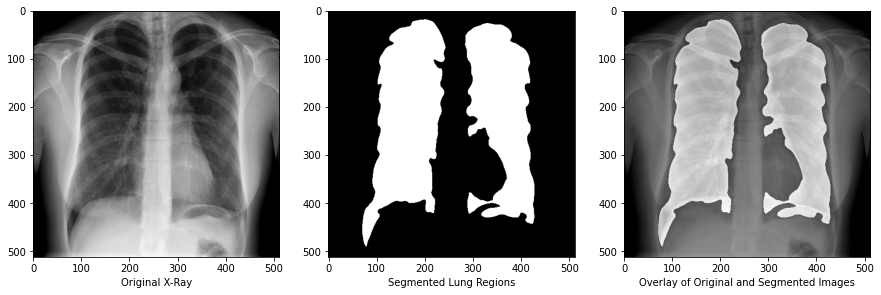

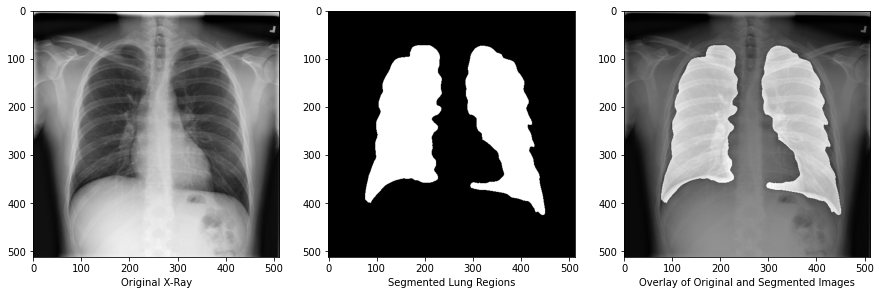

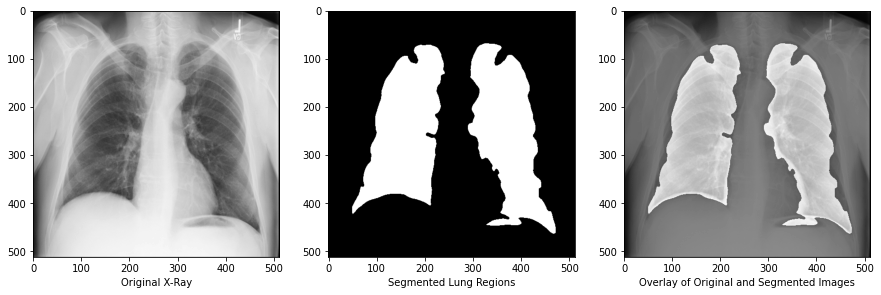

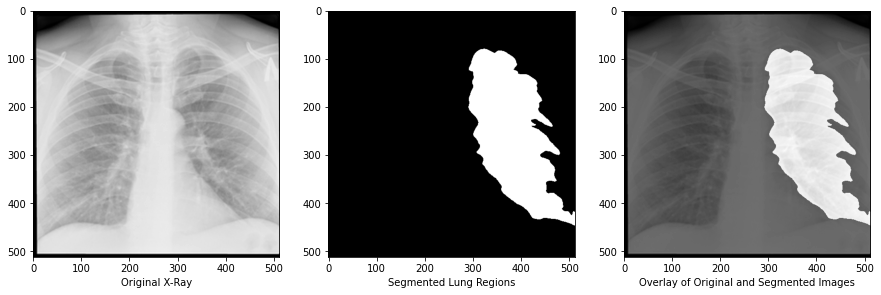

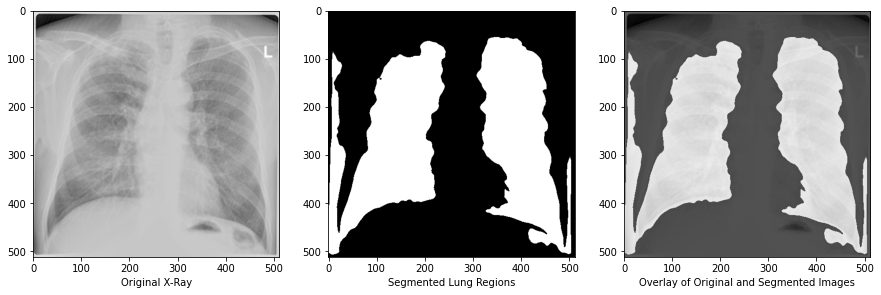

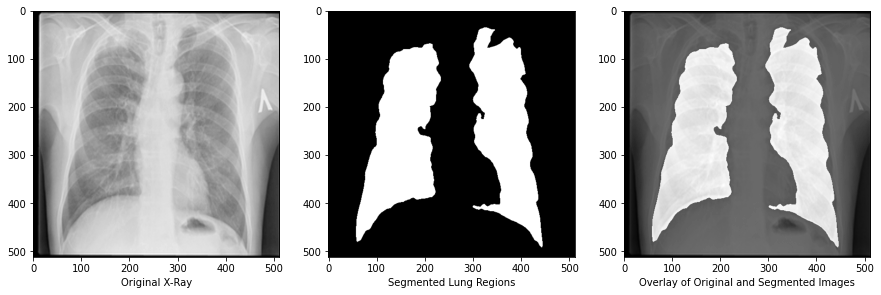

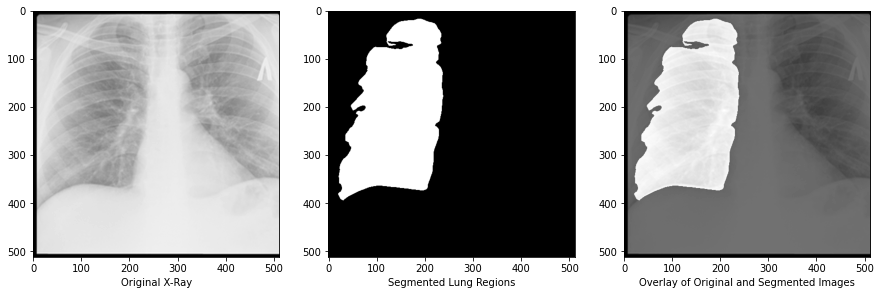

In [ ]:
SegmentedLung = SegmentLung('/content/Normal-4.png')
img2 = cv2.imread("/content/Normal-4.png",0)


plt.figure(figsize = (15,15))
plt.subplot(1,3,1)
plt.xlabel('Original X-Ray')
plt.imshow(img2,cmap='gray')
plt.subplot(1,3,2)
plt.xlabel('Segmented Lung Regions')
plt.imshow(SegmentedLung,cmap='gray')
plt.subplot(1,3,3)
plt.xlabel('Overlay of Original and Segmented Images')
plt.imshow(img2 + SegmentedLung,cmap='gray')




SegmentedLung = SegmentLung('/content/Normal-10.png')
img2 = cv2.imread("/content/Normal-10.png",0)


plt.figure(figsize = (15,15))
plt.subplot(1,3,1)
plt.xlabel('Original X-Ray')
plt.imshow(img2,cmap='gray')
plt.subplot(1,3,2)
plt.xlabel('Segmented Lung Regions')
plt.imshow(SegmentedLung,cmap='gray')
plt.subplot(1,3,3)
plt.xlabel('Overlay of Original and Segmented Images')
plt.imshow(img2 + SegmentedLung,cmap='gray')



SegmentedLung = SegmentLung('/content/Normal-6.png')
img2 = cv2.imread("/content/Normal-6.png",0)


plt.figure(figsize = (15,15))
plt.subplot(1,3,1)
plt.xlabel('Original X-Ray')
plt.imshow(img2,cmap='gray')
plt.subplot(1,3,2)
plt.xlabel('Segmented Lung Regions')
plt.imshow(SegmentedLung,cmap='gray')
plt.subplot(1,3,3)
plt.xlabel('Overlay of Original and Segmented Images')
plt.imshow(img2 + SegmentedLung,cmap='gray')


SegmentedLung = SegmentLung('/content/Tuberculosis-9.png')
img2 = cv2.imread("/content/Tuberculosis-9.png",0)


plt.figure(figsize = (15,15))
plt.subplot(1,3,1)
plt.xlabel('Original X-Ray')
plt.imshow(img2,cmap='gray')
plt.subplot(1,3,2)
plt.xlabel('Segmented Lung Regions')
plt.imshow(SegmentedLung,cmap='gray')
plt.subplot(1,3,3)
plt.xlabel('Overlay of Original and Segmented Images')
plt.imshow(img2 + SegmentedLung,cmap='gray')



SegmentedLung = SegmentLung('/content/Tuberculosis-4.png')
img2 = cv2.imread("/content/Tuberculosis-4.png",0)


plt.figure(figsize = (15,15))
plt.subplot(1,3,1)
plt.xlabel('Original X-Ray')
plt.imshow(img2,cmap='gray')
plt.subplot(1,3,2)
plt.xlabel('Segmented Lung Regions')
plt.imshow(SegmentedLung,cmap='gray')
plt.subplot(1,3,3)
plt.xlabel('Overlay of Original and Segmented Images')
plt.imshow(img2 + SegmentedLung,cmap='gray')


SegmentedLung = SegmentLung('/content/Tuberculosis-5.png')
img2 = cv2.imread("/content/Tuberculosis-5.png",0)


plt.figure(figsize = (15,15))
plt.subplot(1,3,1)
plt.xlabel('Original X-Ray')
plt.imshow(img2,cmap='gray')
plt.subplot(1,3,2)
plt.xlabel('Segmented Lung Regions')
plt.imshow(SegmentedLung,cmap='gray')
plt.subplot(1,3,3)
plt.xlabel('Overlay of Original and Segmented Images')
plt.imshow(img2 + SegmentedLung,cmap='gray')



SegmentedLung = SegmentLung('/content/Tuberculosis-7.png')
img2 = cv2.imread("/content/Tuberculosis-7.png",0)


plt.figure(figsize = (15,15))
plt.subplot(1,3,1)
plt.xlabel('Original X-Ray')
plt.imshow(img2,cmap='gray')
plt.subplot(1,3,2)
plt.xlabel('Segmented Lung Regions')
plt.imshow(SegmentedLung,cmap='gray')
plt.subplot(1,3,3)
plt.xlabel('Overlay of Original and Segmented Images')
plt.imshow(img2 + SegmentedLung,cmap='gray')


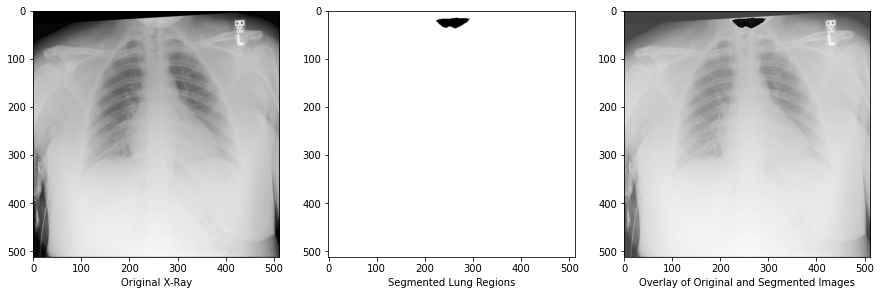

In [ ]:
SegmentedLung = SegmentLung('/content/Normal-5.png')
img2 = cv2.imread("/content/Normal-5.png",0)


plt.figure(figsize = (15,15))
plt.subplot(1,3,1)
plt.xlabel('Original X-Ray')
plt.imshow(img2,cmap='gray')
plt.subplot(1,3,2)
plt.xlabel('Segmented Lung Regions')
plt.imshow(SegmentedLung,cmap='gray')
plt.subplot(1,3,3)
plt.xlabel('Overlay of Original and Segmented Images')
plt.imshow(img2 + SegmentedLung,cmap='gray')

## Following Codes are used to create figures for presentation and the report

<ipython-input-76-822eda2a817b>:15: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(hist)
<ipython-input-76-822eda2a817b>:22: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(hist2)


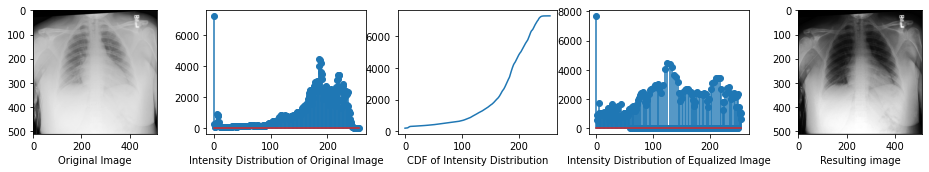

In [ ]:
img = cv2.imread("/content/Normal-5.png",0)
hist,bins = np.histogram(img.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()

equ = cv2.equalizeHist(img)
hist2,bins2 = np.histogram(equ.flatten(),256,[0,256])

plt.figure(figsize=(20,5))
plt.subplot(2,6,1)
plt.imshow(img,cmap='gray')
plt.xlabel('Original Image')
plt.subplot(2,6,2)
plt.xlabel('Intensity Distribution of Original Image')
plt.stem(hist)
plt.subplot(2,6,3)
plt.xlabel('CDF of Intensity Distribution')
plt.plot(cdf_normalized)
#plt.figure(figsize=(9,5))
plt.subplot(2,6,4)
plt.xlabel('Intensity Distribution of Equalized Image')
plt.stem(hist2)
plt.subplot(2,6,5)
plt.xlabel('Resulting image')
plt.imshow(equ,cmap='gray')

Text(0.5, 0, 'Result of CLAHE')

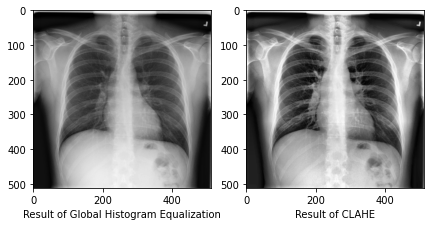

In [7]:
img = cv2.imread("/content/Normal-10.png",0)

clahe = cv2.createCLAHE(clipLimit=3.0 , tileGridSize=(4,4))
cl1 = clahe.apply(img)
equ = cv2.equalizeHist(img)



plt.figure(figsize=(7,7))
plt.subplot(1,2,1)
plt.imshow(img,cmap='gray')
plt.xlabel('Result of Global Histogram Equalization')
plt.subplot(1,2,2)
plt.imshow(cl1,cmap='gray')
plt.xlabel('Result of CLAHE')


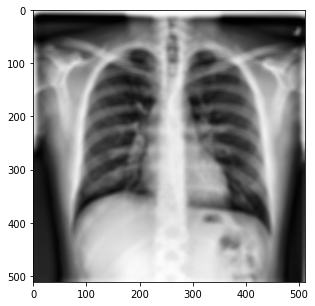

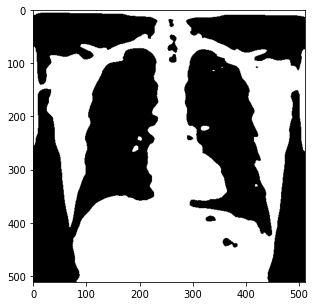

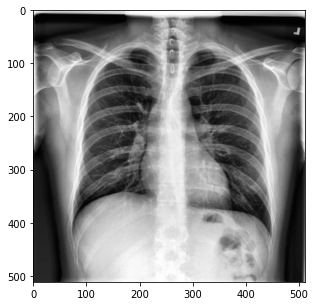

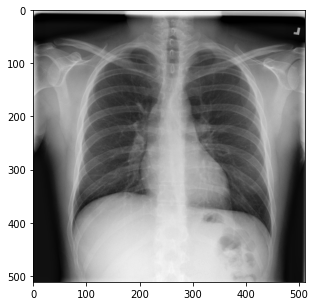

In [8]:
img = cv2.imread("/content/Normal-10.png",0)

equ = cv2.equalizeHist(img)

kernel = np.ones((9,9),np.float32)/81
dst0 = cv2.filter2D(equ,-1,kernel)



clahe = cv2.createCLAHE(clipLimit=2.0 , tileGridSize=(8,8))
cl1 = clahe.apply(equ)


dst = cv2.filter2D(cl1,-1,kernel)

ret , th = cv2.threshold(dst , 0 , 255 , cv2.THRESH_BINARY+cv2.THRESH_OTSU)


plt.figure(figsize =(5,5))
plt.imshow(dst , cmap='gray')

plt.figure(figsize =(5,5))
plt.imshow(th,cmap='gray')

plt.figure(figsize =(5,5))
plt.imshow(cl1,cmap='gray')

plt.figure(figsize =(5,5))
plt.imshow(img,cmap='gray')

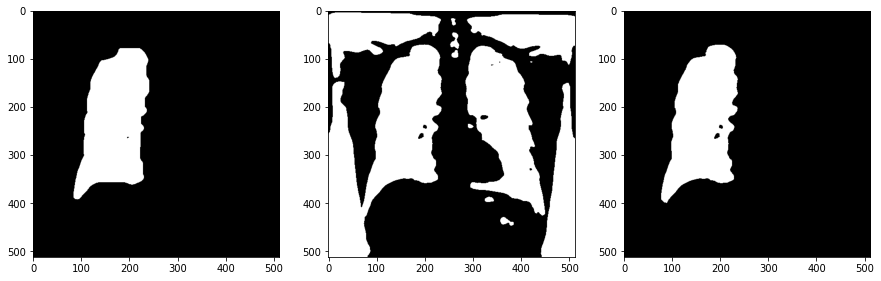

In [17]:
TolalLabels , Labels , Stats , Centroids = cv2.connectedComponentsWithStats(~th , 8, cv2.CV_32S)

Labels_Separated , kernel4= CornerSeperationLeft(Labels,th)
LeftLobeBlob = LeftLobe(Labels_Separated)

Labels = Labels.astype('uint8')

#LeftLobeBlob = cv2.morphologyEx(Labels,cv2.MORPH_OPEN,kernel4)

ReDilation = ReDilationLung(LeftLobeBlob, kernel4, th)


plt.figure(figsize = (15,15))
plt.subplot(1,3,1)
plt.imshow(LeftLobeBlob , cmap='gray')
plt.subplot(1,3,2)
plt.imshow(~th,cmap ='gray')
plt.subplot(1,3,3)
plt.imshow(ReDilation,cmap='gray')